## Seminar 10. Introduction to Reinforcement Learning



# Constructions in combinatorics via neural networks

In the paper  "Constructions in combinatorics via neural networks" by A Z Wagner https://arxiv.org/abs/2104.14516 CE method was used for constructions of counter-examples in combinatorics.

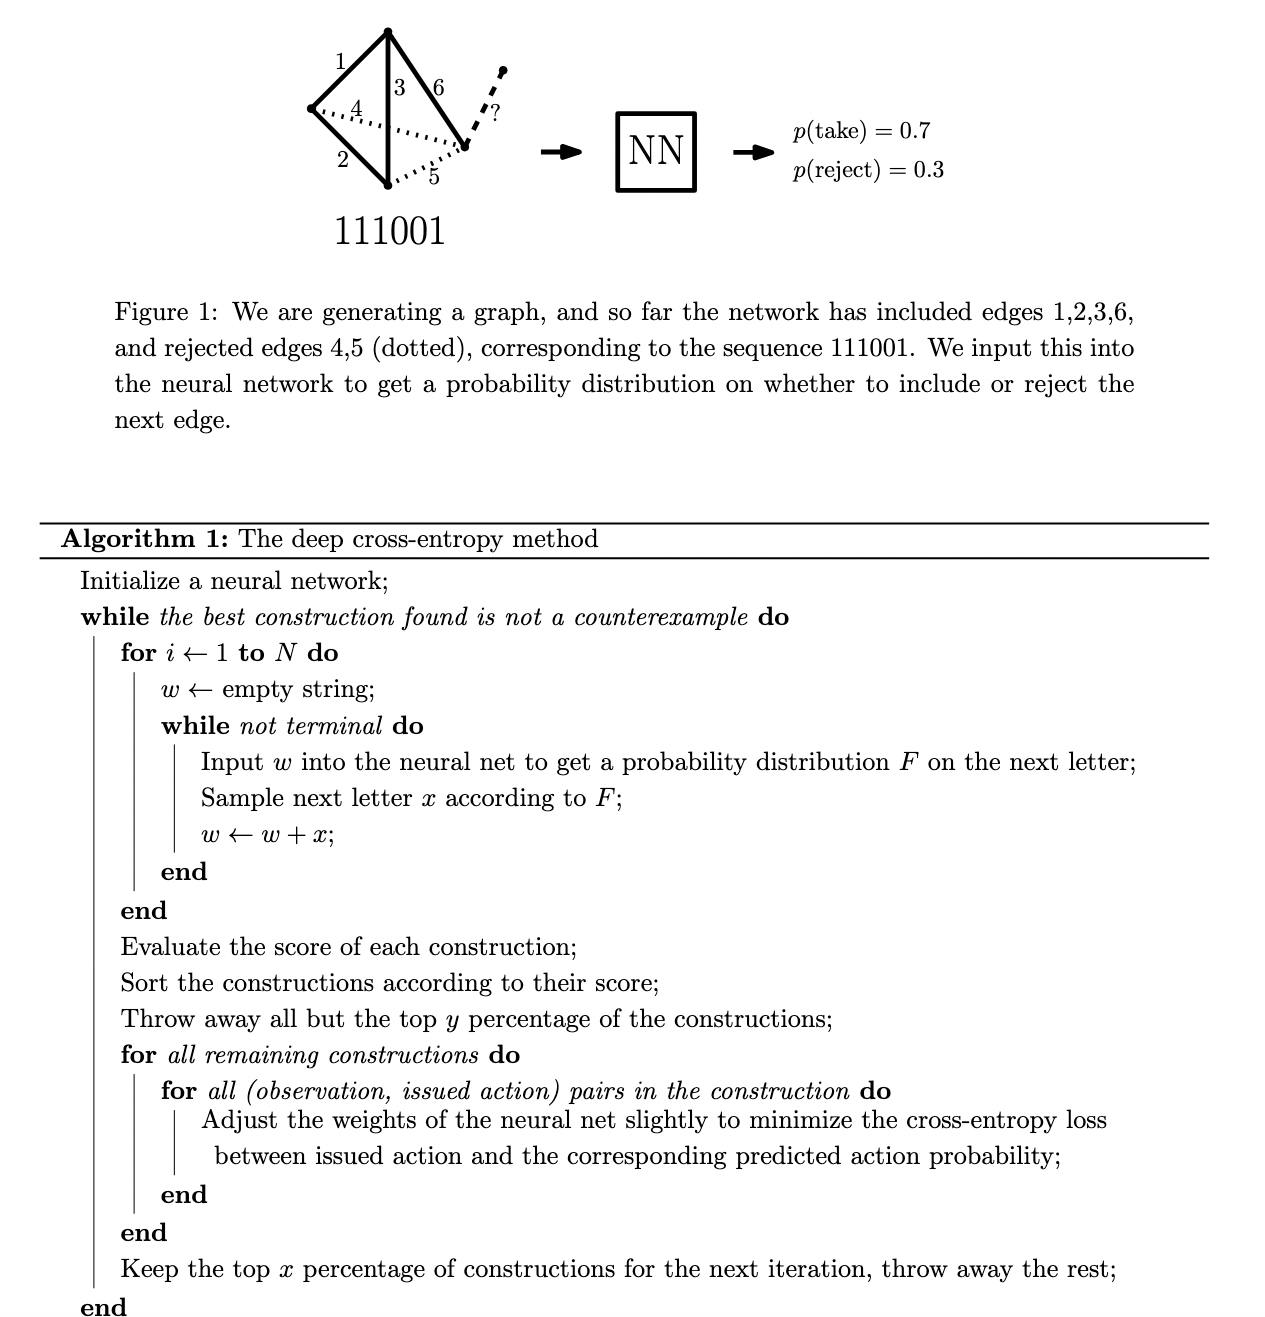

This paper has several implementations https://paperswithcode.com/paper/constructions-in-combinatorics-via-neural We will use the implementation from https://github.com/dpaleka/cross-entropy-for-combinatorics



*   For simplicity, we will **minimize the absolute ratio of the first and the last eigenvalue** of the adjacency matrix of a connected graph. (This will just generate connected bipartite graphs after a few iterations.)


In [ ]:
import networkx as nx #for various graph parameters, such as eigenvalues, macthing number, etc. Does not work with numba (yet)
import random
import numpy as np
from statistics import mean
import pickle
import time
import math
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import itertools
from tqdm import trange, tqdm
import math

Invariants

In [ ]:
N = 20   #number of vertices in the graph. Only used in the reward function, not directly relevant to the algorithm
MYN = int(N*(N-1)/2)  #The length of the word we are generating. Here we are generating a graph, so we create a 0-1 word of length (N choose 2)

LEARNING_RATE = 0.01 #Increase this to make convergence faster, decrease if the algorithm gets stuck in local optima too often.
n_sessions = 200 #number of new sessions per iteration
percentile = 93 #top 100-X percentile we are learning from
super_percentile = 94 #top 100-X percentile that survives to next iteration

FIRST_LAYER_NEURONS = 128 #Number of neurons in the hidden layers.
SECOND_LAYER_NEURONS = 64
THIRD_LAYER_NEURONS = 4

n_actions = 2 #The size of the alphabet. In this file we will assume this is 2. There are a few things we need to change when the alphabet size is larger,
              #such as one-hot encoding the input, and using categorical_crossentropy as a loss function.

observation_space = 2*MYN #Leave this at 2*MYN. The input vector will have size 2*MYN, where the first MYN letters encode our partial word (with zeros on
                          #the positions we haven't considered yet), and the next MYN bits one-hot encode which letter we are considering now.
                          #So e.g. [0,1,0,0,   0,0,1,0] means we have the partial word 01 and we are considering the third letter now.

len_game = MYN
state_dim = (observation_space,)

## Model

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, widths):
        super().__init__()

        num_layers = len(widths)
        layers = [[nn.Linear(widths[i], widths[i+1]), nn.ReLU()] for i in range(num_layers-2)]
        self.layers = [nn.Flatten(1, -1),
                      *list(itertools.chain(*layers)),
                      nn.Linear(widths[-2], widths[-1]),
                      nn.Sigmoid()]

        print(self.layers)
        self.net = nn.Sequential(*self.layers)

    def forward(self, x):
        prob = self.net(x)
        return prob

In [ ]:
# A sequential network with three hidden layers, sigmoid activation in the output.
# It is important that the loss is binary cross-entropy if alphabet size is 2.
model = DenseNet([2*MYN, FIRST_LAYER_NEURONS, SECOND_LAYER_NEURONS, THIRD_LAYER_NEURONS, 1])

# Expertiment: try ADAM optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

Training loop

In [ ]:
def train_network(model, optimizer, train_loader,
                  num_epochs=1, pbar_update_interval=200, print_logs=False):
    '''
    Updates the model parameters (in place) using the given optimizer object.
    Returns `None`.
    '''

    criterion = nn.BCELoss()
    pbar = trange(num_epochs) if print_logs else range(num_epochs)

    for i in pbar:
        for k, batch_data in enumerate(train_loader):
            batch_x = batch_data[:, :-1]
            batch_y = batch_data[:, -1]
            model.zero_grad()
            y_pred = model(batch_x)
            loss = criterion(y_pred, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            if print_logs and k % pbar_update_interval == 0:
                acc = (y_pred.round() == batch_y).sum().float()/(len(batch_y))
                pbar.set_postfix(loss=loss.item(), acc=acc.item())

In [ ]:
def state_to_graph(state):
    #construct the graph G
    adjMatG = np.zeros((N,N),dtype=np.int8) #adjacency matrix determined by the state
    edgeListG = np.zeros((N,N),dtype=np.int8) #neighbor list
    Gdeg = np.zeros(N,dtype=np.int8) #degree sequence
    count = 0
    for i in range(N):
        for j in range(i+1,N):
            if state[count] == 1:
                adjMatG[i][j] = 1
                adjMatG[j][i] = 1
                edgeListG[i][Gdeg[i]] = j
                edgeListG[j][Gdeg[j]] = i
                Gdeg[i] += 1
                Gdeg[j] += 1
            count += 1

    return adjMatG, edgeListG, Gdeg

In [ ]:
from numba import njit


@njit
def bfs(Gdeg,edgeListG):
    #simple breadth first search algorithm, from each vertex
    N = Gdeg.size

    distMat1 = np.zeros((N,N))
    conn = True
    for s in range(N):
        visited = np.zeros(N,dtype=np.int8)

        # Create a queue for BFS. Queues are not suported with njit yet so do it manually
        myQueue = np.zeros(N,dtype=np.int8)
        dist = np.zeros(N,dtype=np.int8)
        startInd = 0
        endInd = 0

        # Mark the source node as visited and enqueue it
        myQueue[endInd] = s
        endInd += 1
        visited[s] = 1

        while endInd > startInd:
            pivot = myQueue[startInd]
            startInd += 1

            for i in range(Gdeg[pivot]):
                if visited[edgeListG[pivot][i]] == 0:
                    myQueue[endInd] = edgeListG[pivot][i]
                    dist[edgeListG[pivot][i]] = dist[pivot] + 1
                    endInd += 1
                    visited[edgeListG[pivot][i]] = 1
        if endInd < N:
            conn = False #not connected

        for i in range(N):
            distMat1[s][i] = dist[i]

    return distMat1, conn

In [ ]:
def score_graph(adjMatG, edgeListG, Gdeg):
    """
    Reward function. The arguments adjMatG, edgeListG, Gdeg are numpy arrays.
    """
    N = Gdeg.size
    INF = 100000

    _, conn = bfs(Gdeg,edgeListG)
    if not conn:
        return -INF

    lambdas = np.flip(np.sort(np.linalg.eigvals(adjMatG)))
    return -abs(lambdas[0]/lambdas[-1])


def score_state(state):
    return score_graph(*state_to_graph(state))

In [ ]:
def display_graph(adjMatG):
    print("Best adjacency matrix in current step:")
    print(adjMatG)

    G = nx.convert_matrix.from_numpy_array(adjMatG)

    plt.clf()
    nx.draw_circular(G)

    plt.axis('equal')
    plt.draw()
    plt.pause(0.001)
    plt.show()


def display_graph(adjMatG):
    print("Best adjacency matrix in current step:")
    print(adjMatG)

    G = nx.convert_matrix.from_numpy_array(adjMatG)

    # Try bipartite coloring first
    if nx.is_bipartite(G):
        print("Graph is bipartite. Using 2-coloring.")
        color_map = {}
        left, right = nx.bipartite.sets(G)
        for node in left:
            color_map[node] = 0
        for node in right:
            color_map[node] = 1
        num_colors = 2
    else:
        print("Graph is not bipartite. Using greedy coloring.")
        color_map = nx.coloring.greedy_color(G, strategy="largest_first")
        num_colors = len(set(color_map.values()))

    print(f"Graph colored with {num_colors} colors.")

    # Map color indices to matplotlib colors
    color_list = plt.cm.tab10.colors
    node_colors = [color_list[color_map[node] % len(color_list)] for node in G.nodes()]

    # Draw graph with colored nodes
    plt.clf()
    nx.draw_circular(G, with_labels=True, node_color=node_colors, edgecolors='black')

    plt.axis('equal')
    plt.draw()
    plt.pause(0.001)
    plt.show()

In [ ]:
def play_game(n_sessions, actions,state_next,states,prob, step, total_score):

    for i in range(n_sessions):
        if np.random.rand() < prob[i]:
            action = 1
        else:
            action = 0
        actions[i][step-1] = action
        state_next[i] = states[i,:,step-1]

        if (action > 0):
            state_next[i][step-1] = action
        state_next[i][MYN + step-1] = 0
        if (step < MYN):
            state_next[i][MYN + step] = 1
        #calculate final score
        terminal = step == MYN
        if terminal:
            total_score[i] = score_state(state_next[i])

        # record sessions
        if not terminal:
            states[i,:,step] = state_next[i]

    return actions, state_next,states, total_score, terminal

In [ ]:
def generate_session(agent, n_sessions, verbose = 1):
    """
    Play n_session games using agent neural network.
    Terminate when games finish

    Code inspired by https://github.com/yandexdataschool/Practical_RL/blob/master/week01_intro/deep_crossentropy_method.ipynb
    """
    states =  np.zeros([n_sessions, observation_space, len_game], dtype=int)
    actions = np.zeros([n_sessions, len_game], dtype = int)
    state_next = np.zeros([n_sessions,observation_space], dtype = int)
    prob = np.zeros(n_sessions)
    states[:,MYN,0] = 1
    step = 0
    total_score = np.zeros([n_sessions])
    pred_time = 0
    play_time = 0

    while (True):
        step += 1
        tic = time.time()
        prob = agent(torch.from_numpy(states[:,:,step-1]).to(torch.float))
        prob = prob.detach().cpu().numpy()

        pred_time += time.time()-tic
        tic = time.time()
        actions, state_next, states, total_score, terminal = play_game(
                n_sessions, actions,state_next, states,prob, step, total_score)
        play_time += time.time()-tic

        if terminal:
            break
    if (verbose):
        print("Predict: "+str(pred_time)+", play: " + str(play_time))
    return states, actions, total_score

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    This function was mostly taken from https://github.com/yandexdataschool/Practical_RL/blob/master/week01_intro/deep_crossentropy_method.ipynb
    If this function is the bottleneck, it can easily be sped up using numba
    """
    counter = n_sessions * (100.0 - percentile) / 100.0
    reward_threshold = np.percentile(rewards_batch,percentile)

    elite_states = []
    elite_actions = []
    elite_rewards = []
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold-0.0000001:
            if (counter > 0) or (rewards_batch[i] >= reward_threshold+0.0000001):
                for item in states_batch[i]:
                    elite_states.append(item.tolist())
                for item in actions_batch[i]:
                    elite_actions.append(item)
            counter -= 1
    elite_states = np.array(elite_states, dtype = int)
    elite_actions = np.array(elite_actions, dtype = int)
    return elite_states, elite_actions

def select_super_sessions(states_batch, actions_batch, rewards_batch, percentile=90):
    """
    Select all the sessions that will survive to the next generation
    Similar to select_elites function
    If this function is the bottleneck, it can easily be sped up using numba
    """

    counter = n_sessions * (100.0 - percentile) / 100.0
    reward_threshold = np.percentile(rewards_batch,percentile)

    super_states = []
    super_actions = []
    super_rewards = []
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold-0.0000001:
            if (counter > 0) or (rewards_batch[i] >= reward_threshold+0.0000001):
                super_states.append(states_batch[i])
                super_actions.append(actions_batch[i])
                super_rewards.append(rewards_batch[i])
                counter -= 1
    super_states = np.array(super_states, dtype = int)
    super_actions = np.array(super_actions, dtype = int)
    super_rewards = np.array(super_rewards)
    return super_states, super_actions, super_rewards

In [ ]:
super_states =  np.empty((0,len_game,observation_space), dtype = int)
super_actions = np.array([], dtype = int)
super_rewards = np.array([])
sessgen_time = 0
fit_time = 0
score_time = 0


myRand = random.randint(0,1000) #used in the filename

NUM_SESSIONS = 200
for i in range(NUM_SESSIONS): #increase NUM_SESSIONS if necessary
    #generate new sessions
    #performance can be improved with joblib
    tic = time.time()
    sessions = generate_session(model,n_sessions,0) #change 0 to 1 to print out how much time each step in generate_session takes
    sessgen_time = time.time()-tic
    tic = time.time()

    states_batch = np.array(sessions[0], dtype = int)
    actions_batch = np.array(sessions[1], dtype = int)
    rewards_batch = np.array(sessions[2])
    states_batch = np.transpose(states_batch,axes=[0,2,1])

    states_batch = np.append(states_batch,super_states,axis=0)

    if i>0:
        actions_batch = np.append(actions_batch,np.array(super_actions),axis=0)
    rewards_batch = np.append(rewards_batch,super_rewards)

    randomcomp_time = time.time()-tic
    tic = time.time()

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile) #pick the sessions to learn from
    select1_time = time.time()-tic

    tic = time.time()
    super_sessions = select_super_sessions(states_batch, actions_batch, rewards_batch, percentile=super_percentile) #pick the sessions to survive
    select2_time = time.time()-tic

    tic = time.time()
    super_sessions = [(super_sessions[0][i], super_sessions[1][i], super_sessions[2][i]) for i in range(len(super_sessions[2]))]
    super_sessions.sort(key=lambda super_sessions: super_sessions[2],reverse=True)
    select3_time = time.time()-tic

    tic = time.time()

    train_data = torch.from_numpy(np.column_stack((elite_states, elite_actions)))
    train_data = train_data.to(torch.float)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)
    train_network(model, optimizer, train_loader)
    fit_time = time.time()-tic

    tic = time.time()

    super_states = [super_sessions[i][0] for i in range(len(super_sessions))]
    super_actions = [super_sessions[i][1] for i in range(len(super_sessions))]
    super_rewards = [super_sessions[i][2] for i in range(len(super_sessions))]

    rewards_batch.sort()
    mean_all_reward = np.mean(rewards_batch[-100:])
    mean_best_reward = np.mean(super_rewards)

    score_time = time.time()-tic

    if (i%20 == 1):
        print("\n" + str(i) +  ". Best individuals: " + str(np.flip(np.sort(super_rewards))))

        #uncomment below line to print out how much time each step in this loop takes.
        print(    "Mean reward: " + str(mean_all_reward) + "\nSessgen: " + str(sessgen_time) + ", other: " + str(randomcomp_time) + ", select1: " + str(select1_time) + ", select2: " + str(select2_time) + ", select3: " + str(select3_time) +  ", fit: " + str(fit_time) + ", score: " + str(score_time))


        display_graph(state_to_graph(super_actions[0])[0])

    if (i%20 == 1): #Write all important info to files every 20 iterations
        with open('best_species_pickle_'+str(myRand)+'.txt', 'wb') as fp:
            pickle.dump(super_actions, fp)
        with open('best_species_txt_'+str(myRand)+'.txt', 'w') as f:
            for item in super_actions:
                f.write(str(item))
                f.write("\n")
        with open('best_species_rewards_'+str(myRand)+'.txt', 'w') as f:
            for item in super_rewards:
                f.write(str(item))
                f.write("\n")
        with open('best_100_rewards_'+str(myRand)+'.txt', 'a') as f:
            f.write(str(mean_all_reward)+"\n")
        with open('best_elite_rewards_'+str(myRand)+'.txt', 'a') as f:
            f.write(str(mean_best_reward)+"\n")
    if (i%200==2): # To create a timeline, like in Figure 3
        with open('best_species_timeline_txt_'+str(myRand)+'.txt', 'a') as f:
            f.write(str(super_actions[0]))
            f.write("\n")

## Conclusion

We minimized the absolute ratio of the first and the last eigenvalue of the adjacency matrix. Let's check that our model generates **connected bipartite graphs**.


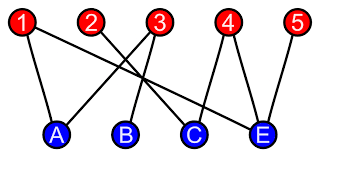

In [ ]:
def is_bipartite(adjMatG):
  """
  Checks if a graph is bipartite using a breadth-first search algorithm.
  """
  num_vertices = len(adjMatG)
  color = [-1] * num_vertices  # -1: uncolored, 0: color 1, 1: color 2

  def bfs(start_node):
    queue = [start_node]
    color[start_node] = 0

    while queue:
      node = queue.pop(0)
      for neighbor in range(num_vertices):
        if adjMatG[node][neighbor] == 1:
          if color[neighbor] == -1:
            color[neighbor] = 1 - color[node]
            queue.append(neighbor)
          elif color[neighbor] == color[node]:
            return False  # Not bipartite
    return True

  for node in range(num_vertices):
    if color[node] == -1:
      if not bfs(node):
        return False

  return True

# Example usage (assuming you have adjMatG defined)
adjMatG = state_to_graph(super_actions[0])[0]
if is_bipartite(adjMatG):
  print("The graph is bipartite.")
else:
  print("The graph is not bipartite.")

This result aligns with theory. Let $\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n$ be the eigenvalues of the adjacency matrix.

*   On one hand, by the Perron-Frobenius theorem, $\lambda_1 \geq - \lambda_n$.
*   On the other hand, for a connected graph $\lambda_n = - \lambda_1$ if and only if it is bipartite.

For details, see e.g. https://jasoncantarella.com/downloads/sagt-interlacing.pdf
